In [1]:
from netCDF4 import Dataset, MFDataset, num2date
import matplotlib as mpl
#mpl.use('Agg')
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmocean import cm as cmo
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import multiprocessing as mp

import sys
sys.path.append("/pf/a/a270046/hierarchy/pyfesom-dev/")

import pyfesom as pf
import gc
import datetime
import os

import sys
import gc
import datetime
import os
from cartopy.util import add_cyclic_point
import math
import xarray as xr

In [2]:
ls /work/ab0995/a270088/THOMASR/

AGUV_salt_2078_2107.nc  BOLD_v_2078_2107.nc     GLOB_u_2078_2107.nc
AGUV_temp_2078_2107.nc  CORE_salt_2078_2107.nc  GLOB_v_2078_2107.nc
AGUV_u_2078_2107.nc     CORE_temp_2078_2107.nc  REF_salt_1921_1950.nc
AGUV_v_2078_2107.nc     CORE_u_2078_2107.nc     REF_temp_1921_1950.nc
BOLD_salt_2078_2107.nc  CORE_v_2078_2107.nc     REF_u_1921_1950.nc
BOLD_temp_2078_2107.nc  GLOB_salt_2078_2107.nc  REF_v_1921_1950.nc
BOLD_u_2078_2107.nc     GLOB_temp_2078_2107.nc


#### load climatology

In [3]:
# load climatology
clim = pf.climatology('/work/bm0944/a270046/DATA/climatology/', climname='phc') # climname='phc'|'woa05'

/pf/a/a270046/hierarchy/pyfesom-dev/pyfesom/climatology.py:83: RuntimeWarning: invalid value encountered in greater
  self.T = np.copy(ncfile.variables['temp'][:,:,:])
/pf/a/a270046/hierarchy/pyfesom-dev/pyfesom/climatology.py:92: RuntimeWarning: invalid value encountered in greater
  self.S=np.copy(ncfile.variables['salt'][:,:,:])
/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


#### do everything for CORE (LR) first

In [59]:
# load CORE mesh
meshpath  ='/work/bm0944/input/CORE2_final/'
mesh_core = pf.load_mesh(meshpath, get3d=True, usepickle=False, usejoblib=True)

# load LR data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/CORE_temp_2078_2107.nc')
f_coretemp = fl.temp.data
fl.close()

# load LR data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/CORE_salt_2078_2107.nc')
f_coresalt = fl.salt.data
fl.close()

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/joblib_mesh


In [60]:
mesh=mesh_core
dataT=f_coretemp
dataS=f_coresalt

In [61]:
mesh.lump2.sum()/10**12 # total ocean area in million km^2

364.74921981951758

#### define box in front of Gibraltar

In [62]:
# box definition
bbox_lon_start=-30
bbox_lon_end=-5
bbox_lat_start=40
bbox_lat_end=20 #30

<IPython.core.display.Javascript object>


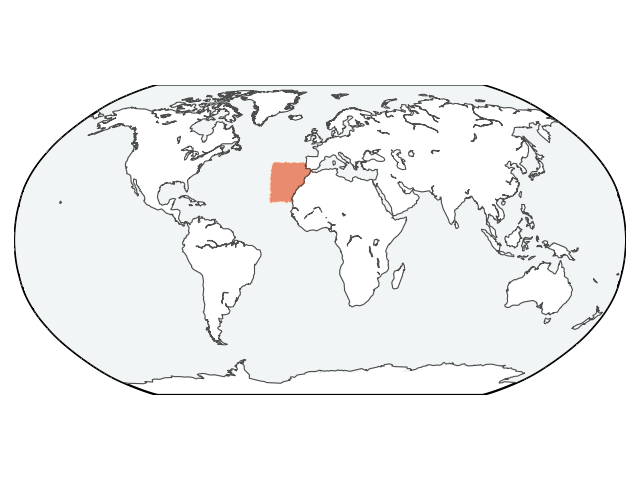

In [63]:
# plot the region as a test

# find 2D indices inside the box
bbox_lonrange=np.logical_and(bbox_lon_start<=mesh.x2,mesh.x2<=bbox_lon_end)
bbox_latrange=np.logical_and(bbox_lat_end<=mesh.y2,mesh.y2<=bbox_lat_start)
box_2dindices=np.logical_and(bbox_latrange,bbox_lonrange)
box_2dindices.shape, mesh.n2d, np.sum(box_2dindices)

#
# get data at that level
level_data, elem_no_nan = pf.get_data(data, mesh, depth=0., verbose=False)
plotfield=np.zeros(mesh.n2d)
plotfield[box_2dindices]=1.

# for checking level data
fig1, ax1 = plt.subplots()

cmap=cm.RdBu_r

#-- plot
map = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = map(mesh.x2, mesh.y2)

levels = np.arange(-2., 2.+.1, .1) #-- contour levels for temp

plt.tricontourf(x, y, elem_no_nan, plotfield, levels=levels, cmap=cmap, extend='both') #cmap_correlations256

map.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.3', antialiased=1)
map.drawmapboundary(linewidth=2.0, color='black')
#cbar = plt.colorbar(orientation='horizontal', pad=0.03);

plt.tight_layout()
plt.show()

In [107]:
from matplotlib.backends.backend_pdf import PdfPages
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/'+'gibraltar_box.pdf')
   pp.savefig(fig1,bbox_inches = 'tight')
   pp.close()

In [64]:
def plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh, data3D):
    
    # find 2D indices inside the box
    bbox_lonrange=np.logical_and(bbox_lon_start<=mesh.x2,mesh.x2<=bbox_lon_end)
    bbox_latrange=np.logical_and(bbox_lat_end<=mesh.y2,mesh.y2<=bbox_lat_start)
    box_2dindices=np.logical_and(bbox_latrange,bbox_lonrange)
    box_2dindices.shape, mesh.n2d, np.sum(box_2dindices)
    
    # initialize profile array
    profile_wgtmean=np.zeros(mesh.zlevs.shape[0])

    # for every model level...
    for idx, depth in enumerate(mesh.zlevs):
    
        # get data at that level
        level_data, elem_no_nan = pf.get_data(data3D, mesh, depth=depth, verbose=False)
    
        # set everything outside box to nan
        level_data[box_2dindices==False]=np.nan 
    
        # do an area-weighted mean; divide by area of box
        profile_wgtmean[idx]=np.nansum(level_data*mesh.lump2)/mesh.lump2[~np.isnan(level_data)].sum()
        
    return profile_wgtmean, mesh.zlevs

In [65]:
# profile for LR (last 30 years)
profileT_LR, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataT)
profileS_LR, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataS)

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


#### plot the profile

<IPython.core.display.Javascript object>


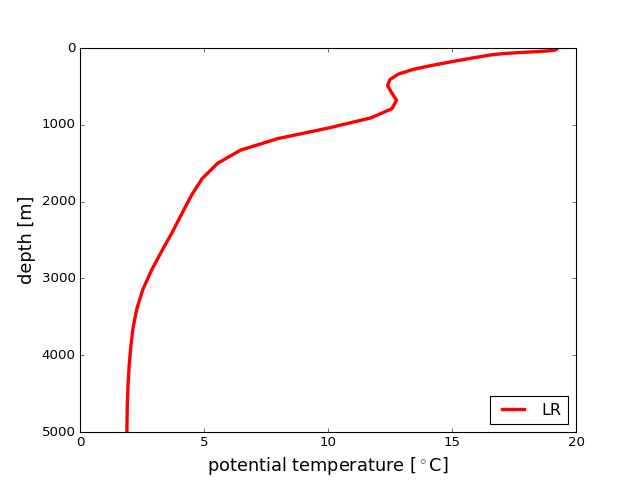

In [66]:
# plot everything
fig1, ax1 = plt.subplots()

plt.plot(profile_LR, depths, 'r', lw=3, label='LR')
plt.gca().invert_yaxis()

#ax1.set_xlim([0, 5])
ax1.set_ylim([5000, 0])

plt.xlabel('potential temperature [$^\circ$C]', fontsize=16)
plt.ylabel('depth [m]', fontsize=16)
plt.legend(loc='lower right')

plt.axis()

plt.show()

#### same for the other grids

In [67]:
# load REF mesh
meshpath  ='/work/bm0944/input/mesh_ref87k/'
mesh_ref = pf.load_mesh(meshpath, get3d=False, usepickle=False, usejoblib=True)

# load REF data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/REF_temp_1921_1950.nc')
f_reftemp = fl.temp.data
fl.close()

# load REF data; open the mean of salt over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/REF_salt_1921_1950.nc')
f_refsalt = fl.salt.data
fl.close()

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/mesh_ref87k/joblib_mesh


In [68]:
mesh=mesh_ref
dataT=f_reftemp
dataS=f_refsalt

In [69]:
# profile for LR (last 30 years)
profileT_REF, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataT)
profileS_REF, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataS)

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


#### AGUV

In [70]:
# load REF mesh
meshpath  ='/work/bm0944/input/aguv/'
mesh_aguv = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=False, usepickle=False, usejoblib=True)

# load AGUV data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/AGUV_temp_2078_2107.nc')
f_aguvtemp = fl.temp.data
fl.close()

# load AGUV data; open the mean of salt over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/AGUV_salt_2078_2107.nc')
f_aguvsalt = fl.salt.data
fl.close()

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/aguv/joblib_mesh


In [71]:
mesh=mesh_aguv
dataT=f_aguvtemp
dataS=f_aguvsalt

In [72]:
# profile for LR (last 30 years)
profileT_AGUV, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataT)
profileS_AGUV, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataS)

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


#### GLOB

In [73]:
meshpath  ='/work/ab0995/a270046/fesom-meshes/glob/'
mesh_glob = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=False, usepickle=False, usejoblib=True)

# load GLOB data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/GLOB_temp_2078_2107.nc')
f_globtemp = fl.temp.data
fl.close()

# load GLOB data; open the mean of salt over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/GLOB_salt_2078_2107.nc')
f_globsalt = fl.salt.data
fl.close()

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270046/fesom-meshes/glob/joblib_mesh


In [74]:
mesh=mesh_glob
dataT=f_globtemp
dataS=f_globsalt

In [75]:
profileT_GLOB, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataT)
profileS_GLOB, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataS)

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


#### BOLD

In [76]:
meshpath  ='/work/ab0995/a270067/fesom/bold/mesh_Agulhas/'
mesh_bold = pf.load_mesh(meshpath, abg=[0, 0, 0], get3d=False, usepickle=False, usejoblib=True)

# load BOLD data; open the mean of temp over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/BOLD_temp_2078_2107.nc')
f_boldtemp = fl.temp.data
fl.close()

# load BOLD data; open the mean of salt over the last 30 years
fl = xr.open_dataset('/work/ab0995/a270088/THOMASR/BOLD_salt_2078_2107.nc')
f_boldsalt = fl.salt.data
fl.close()

The usejoblib == True)
The joblib file for python 2 exists.
The mesh will be loaded from /work/ab0995/a270067/fesom/bold/mesh_Agulhas/joblib_mesh


In [77]:
mesh=mesh_bold
dataT=f_boldtemp
dataS=f_boldsalt

In [78]:
profileT_BOLD, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataT)
profileS_BOLD, depths = plot_profile_inregion(bbox_lon_start, bbox_lon_end, bbox_lat_start, bbox_lat_end, mesh=mesh, data3D=dataS)

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


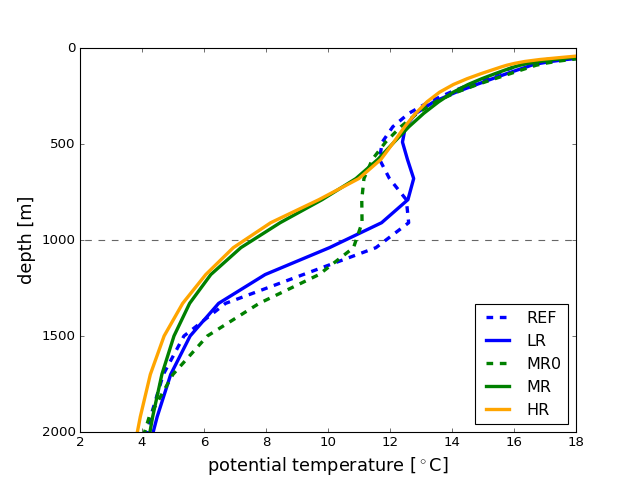

In [79]:
# plot everything
fig1, ax1 = plt.subplots()

plt.plot(profileT_REF, depths, color='blue', lw=3, linestyle='dashed', label='REF')
plt.plot(profileT_LR, depths, color='blue', lw=3, label='LR')
plt.plot(profileT_AGUV, depths, color='green', lw=3, linestyle='dashed', label='MR0')
plt.plot(profileT_GLOB, depths, color='green', lw=3, label='MR')
plt.plot(profileT_BOLD, depths, color='orange', lw=3, label='HR')

plt.gca().invert_yaxis()

plt.hlines(1000.,xmin=0.,xmax=18, linestyle='dashed', color='0.4')

ax1.set_xlim([2., 18.])
ax1.set_ylim([2000, 0])

plt.xlabel('potential temperature [$^\circ$C]', fontsize=16)
plt.ylabel('depth [m]', fontsize=16)
plt.legend(loc='lower right')

plt.axis()

plt.show()

In [27]:
from matplotlib.backends.backend_pdf import PdfPages
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/'+'gibraltar_profiles_last30years.pdf')
   pp.savefig(fig1,bbox_inches = 'tight')
   pp.close()

#### add PHC to the figure

In [80]:
clim.T.shape, clim.x.min(), clim.x.max(), clim.y.min(), clim.y.max(), clim.z

((33, 180, 360),
 -179.5,
 179.5,
 -89.5,
 89.5,
 array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,
          150.,   200.,   250.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
         1750.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
         5500.]))

In [81]:
# find 2D indices of PHC inside the box
PHCbbox_lonrange=np.logical_and(bbox_lon_start<=clim.x,clim.x<=bbox_lon_end)
PHCbbox_latrange=np.logical_and(bbox_lat_end<=clim.y,clim.y<=bbox_lat_start)

In [82]:
climT_box=clim.T[:,PHCbbox_latrange,:]
climS_box=clim.S[:,PHCbbox_latrange,:]

In [83]:
climT_box.shape

(33, 20, 360)

In [84]:
climT_box=climT_box[:,:,PHCbbox_lonrange]
climS_box=climS_box[:,:,PHCbbox_lonrange]

In [86]:
climS_box.shape, climT_box.shape

((33, 20, 25), (33, 20, 25))

<IPython.core.display.Javascript object>


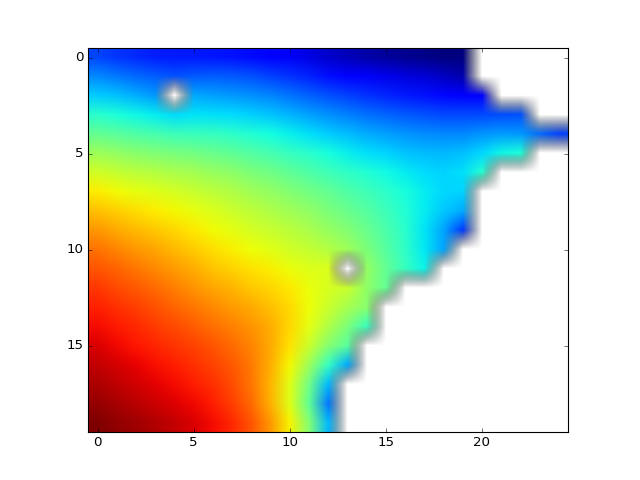

In [89]:
# plot everything
fig1, ax1 = plt.subplots()

plt.imshow(np.flipud(climT_box[0,:,:]))

In [92]:
profileT_PHC=np.nanmean(climT_box[:,:,:],axis=(1,2))
profileS_PHC=np.nanmean(climS_box[:,:,:],axis=(1,2))

In [93]:
profileT_PHC.shape, profileS_PHC.shape, clim.z

((33,),
 (33,),
 array([    0.,    10.,    20.,    30.,    50.,    75.,   100.,   125.,
          150.,   200.,   250.,   300.,   400.,   500.,   600.,   700.,
          800.,   900.,  1000.,  1100.,  1200.,  1300.,  1400.,  1500.,
         1750.,  2000.,  2500.,  3000.,  3500.,  4000.,  4500.,  5000.,
         5500.]))

<IPython.core.display.Javascript object>


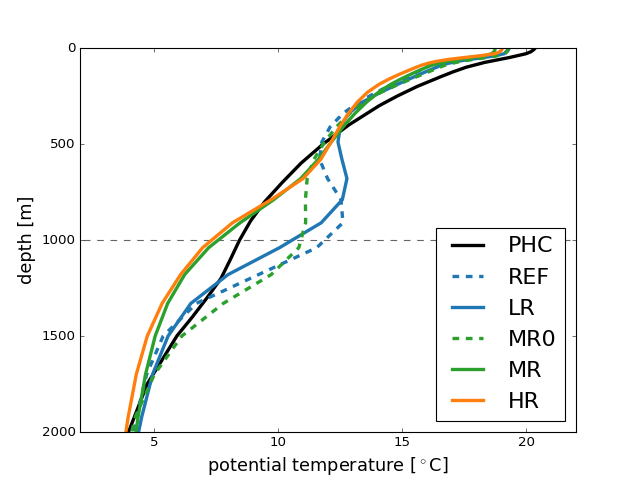

In [94]:
# plot everything
fig2, ax1 = plt.subplots()

#plt.plot(profile_PHC, clim.z, color='white', lw=6, label='PHC')
plt.plot(profileT_PHC, clim.z, color='black', lw=3, label='PHC')


plt.plot(profileT_REF, depths, color='#1f77b4', lw=3, linestyle='dashed', label='REF')
plt.plot(profileT_LR, depths, color='#1f77b4', lw=3, label='LR')
plt.plot(profileT_AGUV, depths, color='#2ca02c', lw=3, linestyle='dashed', label='MR0')
plt.plot(profileT_GLOB, depths, color='#2ca02c', lw=3, label='MR')
plt.plot(profileT_BOLD, depths, color='#ff7f0e', lw=3, label='HR')




plt.gca().invert_yaxis()

plt.hlines(1000.,xmin=0.,xmax=22., linestyle='dashed', color='0.4')

ax1.set_xlim([2., 22.])
ax1.set_ylim([2000, 0])

plt.xlabel('potential temperature [$^\circ$C]', fontsize=16)
plt.ylabel('depth [m]', fontsize=16)
plt.legend(loc='lower right', fontsize=20)

plt.show()

In [95]:
from matplotlib.backends.backend_pdf import PdfPages
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/'+'gibraltar_Tprofiles_last30years_PHC.pdf')
   pp.savefig(fig2,bbox_inches = 'tight')
   pp.close()

<IPython.core.display.Javascript object>


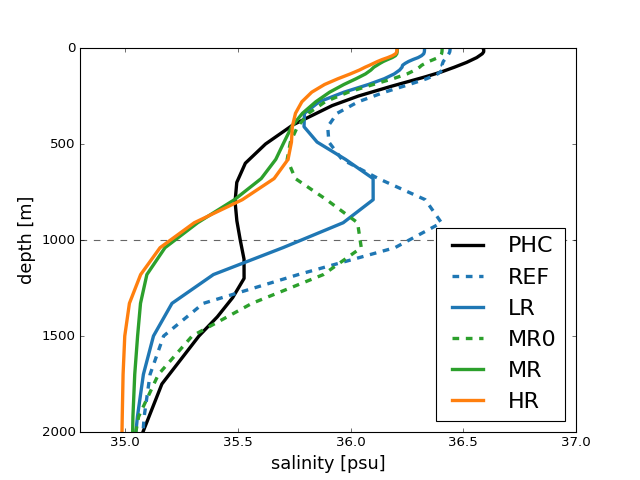

In [100]:
# plot everything
fig3, ax1 = plt.subplots()

#plt.plot(profile_PHC, clim.z, color='white', lw=6, label='PHC')
plt.plot(profileS_PHC, clim.z, color='black', lw=3, label='PHC')


plt.plot(profileS_REF, depths, color='#1f77b4', lw=3, linestyle='dashed', label='REF')
plt.plot(profileS_LR, depths, color='#1f77b4', lw=3, label='LR')
plt.plot(profileS_AGUV, depths, color='#2ca02c', lw=3, linestyle='dashed', label='MR0')
plt.plot(profileS_GLOB, depths, color='#2ca02c', lw=3, label='MR')
plt.plot(profileS_BOLD, depths, color='#ff7f0e', lw=3, label='HR')




plt.gca().invert_yaxis()

plt.hlines(1000.,xmin=34.8,xmax=37., linestyle='dashed', color='0.4')

ax1.set_xlim([34.8, 37.])
ax1.set_ylim([2000, 0])

plt.xlabel('salinity [psu]', fontsize=16)
plt.ylabel('depth [m]', fontsize=16)
plt.legend(loc='lower right', fontsize=20)

plt.show()

In [101]:
from matplotlib.backends.backend_pdf import PdfPages
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/hierarchy/new_figures/'+'gibraltar_Sprofiles_last30years_PHC.pdf')
   pp.savefig(fig3,bbox_inches = 'tight')
   pp.close()